<a href="https://colab.research.google.com/github/daisy-dotcom/ms_pacman/blob/main/ms_pacman_duel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Only run to save to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# run this cell once per Colab session
!apt update
!apt-get install xvfb x11-utils
!python -m pip install --upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text] --no-cache-dir

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,031 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,598 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,396 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [33.9 kB]
Get:13 http:

In [ ]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
#from torchinfo import summary
import os

# create random number generator
rng = np.random.default_rng()

# create and start virtual display
display = Display(backend='xvfb')
display.start()

  if event.key is 'enter':



In [ ]:
import ale_py
gym.register_envs(ale_py)
#env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

## Use GPU if available

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [ ]:
torch.get_default_device()

device(type='cuda', index=0)

#### Decorator to Add Functions to Classes

In [ ]:
# Register functions as methods
# in classes
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

## Modified Q Network
Split the output layer of the network into two streams to estimate the state value function and the action advantage function.

Estimated action value function using the following equation which states that the action value function is the sum of the state-value function and the action advantage function:
${q_\pi(s,a) = v_\pi(s) + a_\pi(s,a)}$


Source: Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 10: Sample Efficient Value Based Methods

In [ ]:
# source: https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/rl/dqn/model.py
class DuelingQNetworkRAM(nn.Module):
    def __init__(self, in_channels, hidden_sizes, output_size, learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layers
        layers.append(nn.Linear(in_channels, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())


        # output layers
        #  outputs a 1D tensor of size 1 with the state value
        self.state_value =  nn.Linear(hidden_sizes[-1], 1)

        # outputs a 1D tensor of size output_size with the action
        # advantage values
        self.adv = nn.Linear(hidden_sizes[-1], output_size)

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam([
            {'params': self.net.parameters()},
            {'params': self.state_value.parameters()},
            {'params': self.adv.parameters()}],
                                          lr=learning_rate)

        # initialise the weights according to dueling network architecture
        self.net.apply(self.init_weights)
        self.state_value.apply(self.init_weights)
        self.adv.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x1 = self.net(x)

        # state value output
        state_value = self.state_value(x1)

        # advantage output
        adv = self.adv(x1)

        state_value = state_value.expand_as(adv)

        # return output of Q-network for the input x
        return state_value + adv - adv.mean(dim=-1, keepdim=True)

    def update(self, inputs, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())
        self.state_value.load_state_dict(qnetwork.state_value.state_dict())
        self.adv.load_state_dict(qnetwork.adv.state_dict())

### Dueling DQN with Prioritised Experience Replay and a Decaying Epsilon

In [ ]:
# Dueling Deep Q-network with Prioritised Experience Replay
class DuelingDQNREPRAM():
    def __init__(self, env, gamma,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 epsilon=0.1,
                 min_epsilon=0.01,
                 tau=0.1,
                 rep_omega=0.2,
                 replay_size=10000,
                 minibatch_size=32,
                 epsilon_update=50000,
                 target_update=20):

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_channels = env.observation_space.shape[0]
        self.state_dims = env.observation_space.shape

        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n

        # create dueling Q-networks for action-value function
        self.qnet = DuelingQNetworkRAM(self.state_channels, hidden_sizes, self.num_actions, learning_rate)
        self.target_qnet = DuelingQNetworkRAM(self.state_channels, hidden_sizes, self.num_actions, learning_rate)

        # copy weights from Q-network to target Q-network
        self.target_qnet.copy_from(self.qnet)

        # initialise replay buffer
        self.replay_buffer = deque(maxlen=replay_size)

        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.init_epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.tau = tau
        self.rep_omega = rep_omega
        self.minibatch_size = minibatch_size
        self.target_update = target_update
        self.target_update_idx = 0
        self.epsilon_update = epsilon_update
        self.epsilon_update_idx = 0

    def behaviour(self, state):
        # exploratory behaviour policy
        if rng.uniform() >= self.epsilon:
            # convert state to torch format
            if not torch.is_tensor(state):
                state = torch.tensor(np.array(state), dtype=torch.float)

            # exploitation with probability 1-epsilon; break ties randomly
            q = self.qnet(state).detach()
            j = rng.permutation(self.num_actions)
            return j[q[j].argmax().item()]
        else:
            # exploration with probability epsilon
            return self.env.action_space.sample()

        self._linear_decay_epsilon_update()

    def policy(self, state):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(np.array(state), dtype=torch.float)

        # greedy policy
        # q = self.qnet(state).detach()
        q = self.qnet(state).detach()
        return q.argmax().item()

    def td_error(self, state, action, reward, next_state, terminated):
        # calculate td error for prioritised experience replay
        #next_action = self.qnet(next_state).detach().argmax()
        #next_q = self.target_qnet(next_state).detach()

        next_action = self.qnet(next_state).detach().argmax()
        next_q = self.target_qnet(next_state).detach()

        td_target = reward + self.gamma*next_q[next_action]
        td_error = td_target - self.qnet(state)[action]
        #td_error = td_target - self.qnet(state)[action]

        return td_error.item()


    def update(self):
        # update Q-network if there is enough experience
        if len(self.replay_buffer) >= self.minibatch_size:

            # select mini-batch of experiences using prioritised experience replay_buffer

            # add a small constant to the td_error in the replay buffer
            # to make sure samples with a TD error = 0 can be replayed
            # so expereinces are sampled stochastically & not greedily
            priorities = np.array([np.abs(sample[5] + 0.02) for idx, sample in enumerate(self.replay_buffer)])
            scaled_priorities = priorities ** self.rep_omega
            pri_sum = np.sum(scaled_priorities)
            probs = scaled_priorities / pri_sum

            #print(probs)

            batch = rng.choice(len(self.replay_buffer), size=self.minibatch_size, replace=False, p=probs)
            #, p=probs)

            # calculate inputs and targets for the transitions in the mini-batch
            inputs = torch.zeros((self.minibatch_size,)+self.state_dims)
            targets = torch.zeros((self.minibatch_size, self.num_actions))

            for n, index in enumerate(batch):
                state, action, reward, next_state, terminated, _ = self.replay_buffer[index]
                # inputs are states
                inputs[n] = state

                # targets are TD targets
                #targets[n, :] = self.target_qnet(state).detach()
                targets[n, :] = torch.squeeze(self.target_qnet(state), dim=0).detach()

                if terminated:
                    targets[n, action] = reward
                else:
                    # double learning
                    # note: we don't break ties randomly (ties are unlikely when weights are initialised randomly)
                    # next_action = self.qnet(next_state).detach().argmax()
                    # next_q = self.target_qnet(next_state).detach()
                    next_action = self.qnet(next_state).detach().argmax()
                    next_q = self.target_qnet(next_state).detach()
                    targets[n, action] = reward + self.gamma*next_q[next_action]

            # train Q-network on the mini-batch
            self.qnet.update(inputs, targets)

        # periodically copy a portion of the weights from
        # Q-network to target Q-network
        self.target_update_idx += 1
        if self.target_update_idx % self.target_update == 0:
            self.update_networks()

    def train(self, max_episodes, stop_criterion, criterion_episodes):
        # train the agent for a number of episodes
        rewards = []
        num_steps = 0
        for episode in range(max_episodes):
            state, _ = env.reset()
            # convert state to torch format
            state = torch.tensor(np.array(state), dtype=torch.float)
            terminated = False
            truncated = False
            rewards.append(0)
            while not (terminated or truncated):
                # select action by following behaviour policy
                action = self.behaviour(state)

                # send the action to the environment
                next_state, reward, terminated, truncated, _ = env.step(action)

                # convert next state to torch format
                next_state = torch.tensor(np.array(next_state), dtype=torch.float)

                # calculate td error for prioritised experience replay and add experience to replay buffer
                per = self.td_error(state, action, reward, next_state, terminated)
                self.replay_buffer.append((state, action, reward, next_state, terminated, per))

                # update Q-network
                self.update()

                state = next_state
                rewards[-1] += reward
                num_steps += 1

            print(f'\rEpisode {episode+1} done: steps = {num_steps}, rewards = {rewards[episode]}     ', end='')

            if episode >= criterion_episodes-1 and stop_criterion(rewards[-criterion_episodes:]):
                print(f'\nStopping criterion satisfied after {episode} episodes')
                break

        # plot rewards received during training
        plt.figure(dpi=100)
        plt.plot(range(1, len(rewards)+1), rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def save(self, path):
        # save network weights to a file
        torch.save(self.qnet.state_dict(), path)
        torch.save(self.target_qnet.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet.copy_from(self.qnet)

## Polyak Averaging for Network Update
Use Polyak averaging to update the target network with a small portion of the online network.


Source: Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 10: Sample Efficient Value Based Methods

In [ ]:
@add_to_class(DuelingDQNREPRAM)
def update_networks(self):
  for target, online in zip(self.target_qnet.parameters(),
                            self.qnet.parameters()):

    target_ratio = (1.0-self.tau) * target.data
    online_ratio = self.tau * online.data
    mix = target_ratio + online_ratio
    target.data.copy_(mix)

## Linearly Decaying Epsilon for Exploration

Allow epsilon to decay linearly from an initial epsilon vale e.g. 1.0 to a target epsilon value e.g., 0.01 over a number of steps to encourage more exploration early on.

Source: Miguel Morales. (2020). Grokking Deep Reinforcement Learning. Chapter 4: Balancing the Gathering and Use of Information

In [ ]:
@add_to_class(DuelingDQNREPRAM)
def _linear_decay_epsilon_update(self):
  epsilon = 1 - self.epsilon_update_idx / self.epsilon_update
  epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
  epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
  self.epsilon_update_idx += 1
  self.epsilon = epsilon

### Ms Pacman

#### Initial Target Update 5000

Episode 700 done: steps = 346730, rewards = 180.0     

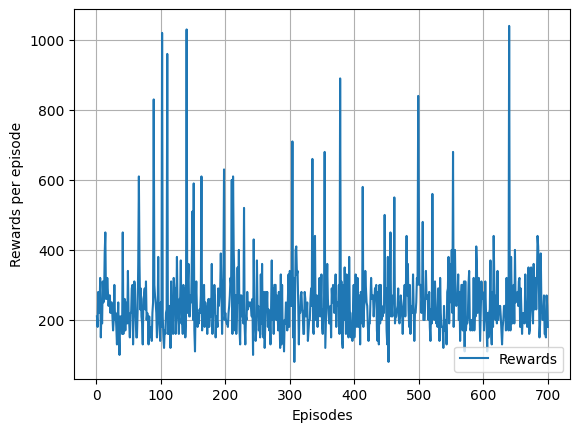

In [ ]:
# create the environment
# source: https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 2.5e-4
epsilon = 1.0
min_epsilon = 0.01
tau = 0.1
rep_omega = 0.2
replay_size = 50000
minibatch_size = 32
target_update = 5000
epsilon_update= 1500000
max_episodes = 700
max_steps = 18000
criterion_episodes = 5

agent = DuelingDQNREPRAM(env,
                gamma=gamma,
                hidden_sizes=hidden_sizes,
                learning_rate=learning_rate,
                epsilon=epsilon,
                min_epsilon=min_epsilon,
                tau=tau,
                rep_omega=rep_omega,
                replay_size=replay_size,
                minibatch_size=minibatch_size,
                target_update=target_update,
                epsilon_update=epsilon_update)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 60.0


#### Reduced Target Update 5000

Episode 700 done: steps = 345078, rewards = 400.0     

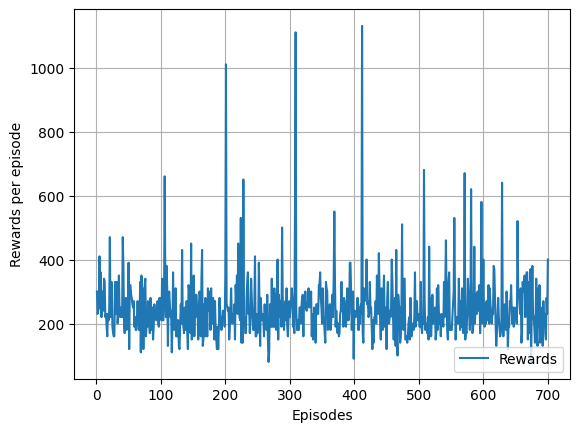

In [ ]:
# create the environment
# source: https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 2.5e-4
epsilon = 1.0
min_epsilon = 0.01
tau = 0.1
rep_omega = 0.2
replay_size = 50000
minibatch_size = 32
target_update = 500
epsilon_update= 1500000
max_episodes = 700
max_steps = 18000
criterion_episodes = 5

agent = DuelingDQNREPRAM(env,
                gamma=gamma,
                hidden_sizes=hidden_sizes,
                learning_rate=learning_rate,
                epsilon=epsilon,
                min_epsilon=min_epsilon,
                tau=tau,
                rep_omega=rep_omega,
                replay_size=replay_size,
                minibatch_size=minibatch_size,
                target_update=target_update,
                epsilon_update=epsilon_update)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 260.0


#### Increasing the Portion of the Online Network Added to the Target Network

Episode 700 done: steps = 351166, rewards = 200.0     

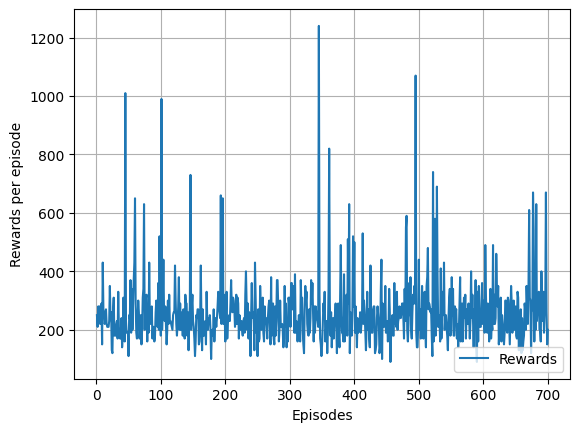

In [ ]:
# create the environment
# source: https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 2.5e-4
epsilon = 1.0
min_epsilon = 0.01
tau = 0.3
rep_omega = 0.2
replay_size = 50000
minibatch_size = 32
target_update = 500
epsilon_update= 1500000
max_episodes = 700
max_steps = 18000
criterion_episodes = 5

agent = DuelingDQNREPRAM(env,
                gamma=gamma,
                hidden_sizes=hidden_sizes,
                learning_rate=learning_rate,
                epsilon=epsilon,
                min_epsilon=min_epsilon,
                tau=tau,
                rep_omega=rep_omega,
                replay_size=replay_size,
                minibatch_size=minibatch_size,
                target_update=target_update,
                epsilon_update=epsilon_update)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 200.0


### Increase Minibatch Size
32 to 64

Episode 700 done: steps = 346480, rewards = 240.0     

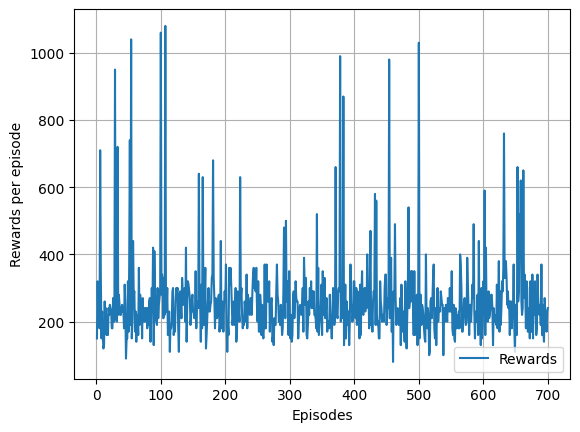

In [ ]:
# create the environment
# source: https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 2.5e-4
epsilon = 1.0
min_epsilon = 0.01
tau = 0.1
rep_omega = 0.2
replay_size = 50000
minibatch_size = 64
target_update = 500
epsilon_update= 1500000
max_episodes = 700
max_steps = 18000
criterion_episodes = 5

agent = DuelingDQNREPRAM(env,
                gamma=gamma,
                hidden_sizes=hidden_sizes,
                learning_rate=learning_rate,
                epsilon=epsilon,
                min_epsilon=min_epsilon,
                tau=tau,
                rep_omega=rep_omega,
                replay_size=replay_size,
                minibatch_size=minibatch_size,
                target_update=target_update,
                epsilon_update=epsilon_update)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 410.0
